In [8]:
from airflow import DAG
from airflow.operators.python import PythonOperator, BranchPythonOperator
from airflow.operators.empty import EmptyOperator
import pendulum
import random

import requests
import pandas as pd
import time
from datetime import datetime
import os
import boto3

# Set up constants
def weather_upload(**kwargs):
    WEATHER_STATIONS = ["KORD", "KENW", "KMDW", "KPNT"]
    BASE_URL = "https://api.weather.gov/stations/{station}/observations/latest"

    # Timestamp of the collection
    time_of_collection = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')

    # Prepare list for collected records
    records = []

    # Collect data
    for station in WEATHER_STATIONS:
        url = BASE_URL.format(station=station)
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("properties", {})
            records.append({
                "timeOfCollection": time_of_collection,
                "timestamp": data.get("timestamp"),
                "station": station,
                "temperature": data.get("temperature", {}).get("value"),
                "dewpoint": data.get("dewpoint", {}).get("value"),
                "windSpeed": data.get("windSpeed", {}).get("value"),
                "barometricPressure": data.get("barometricPressure", {}).get("value"),
                "visibility": data.get("visibility", {}).get("value"),
                "precipitationLastHour": data.get("precipitationLastHour", {}).get("value"),
                "relativeHumidity": data.get("relativeHumidity", {}).get("value"),
                "heatIndex": data.get("heatIndex", {}).get("value")
            })
        else:
            print(f"Failed to fetch data for station {station}")
        time.sleep(2)

    # Create DataFrame
    df = pd.DataFrame(records)

    # Save locally first (optional)
    filename = f"csvs/weather_obs_{datetime.utcnow().strftime('%Y%m%dT%H%M%S')}.csv"
    local_path = f"{filename}"
    df.to_csv(local_path, index=False)




/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_54781/1881397014.py:2 DeprecationWarning: The `airflow.operators.python.PythonOperator` class is deprecated. Please use `'airflow.providers.standard.operators.python.PythonOperator'`.

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_54781/1881397014.py:2 DeprecationWarning: The `airflow.operators.python.BranchPythonOperator` class is deprecated. Please use `'airflow.providers.standard.operators.python.BranchPythonOperator'`.

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_54781/1881397014.py:3 DeprecationWarning: The `airflow.operators.empty.EmptyOperator` class is deprecated. Please use `'airflow.providers.standard.operators.empty.EmptyOperator'`.

In [26]:
weather_upload()

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

LOCAL_OUTPUT_DIR = 'plots'
LOCAL_CSV_DIR = 'csvs'

def create_dashboard_local(target_date=None):
	# Use yesterday's date by default
	if not target_date:
		target_date = (datetime.utcnow() - timedelta(days=1)).strftime("%Y-%m-%d")

	os.makedirs(LOCAL_OUTPUT_DIR, exist_ok=True)

	# Collect all CSVs
	all_files = [f for f in os.listdir(LOCAL_CSV_DIR) if f.endswith(".csv")]
	combined_dfs = []

	for fname in all_files:
		df = pd.read_csv(os.path.join(LOCAL_CSV_DIR, fname))
		if df.empty:
			continue
		df["timestamp"] = pd.to_datetime(df["timestamp"])
		df["date"] = df["timestamp"].dt.date.astype(str)
		if df["date"].iloc[0] == target_date:
			combined_dfs.append(df)

	if not combined_dfs:
		print(f"No data found for {target_date}")
	else:
		df_all = pd.concat(combined_dfs)
		print(f"📊 Loaded {len(df_all)} records from {len(combined_dfs)} files")
	return df_all

df_all = create_dashboard_local()


📊 Loaded 20 records from 5 files


In [42]:
df_all = df_all.sort_values(by="timestamp")
target_date = (datetime.utcnow() - timedelta(days=1)).strftime("%Y-%m-%d")

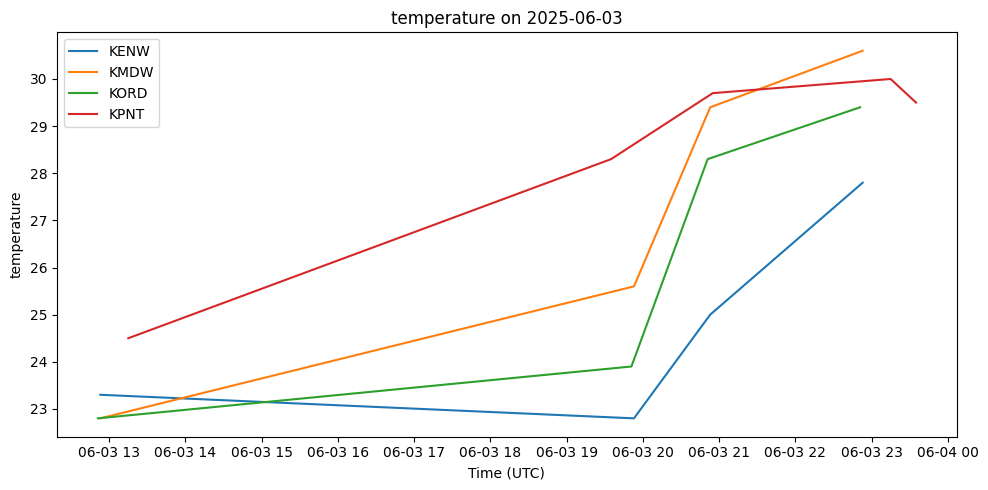

🖼️  Saved: plots/temperature_2025-06-03.png


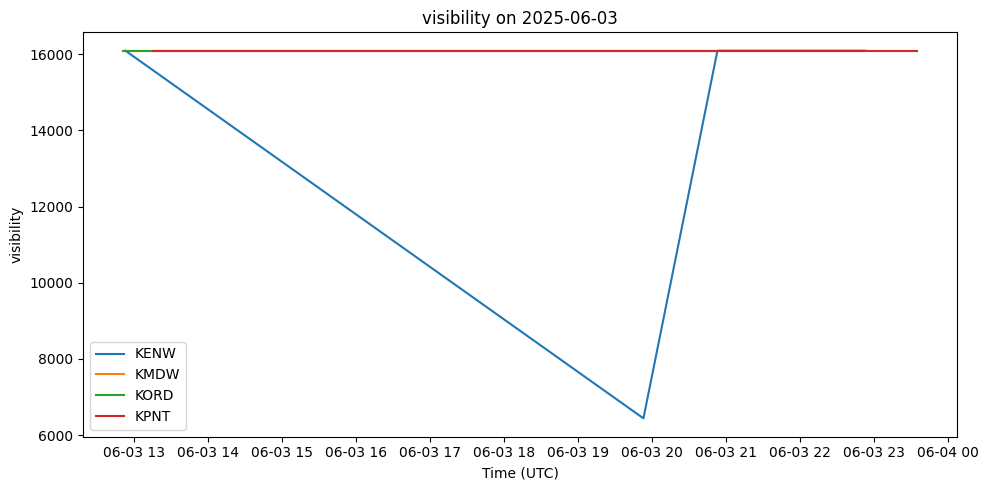

🖼️  Saved: plots/visibility_2025-06-03.png


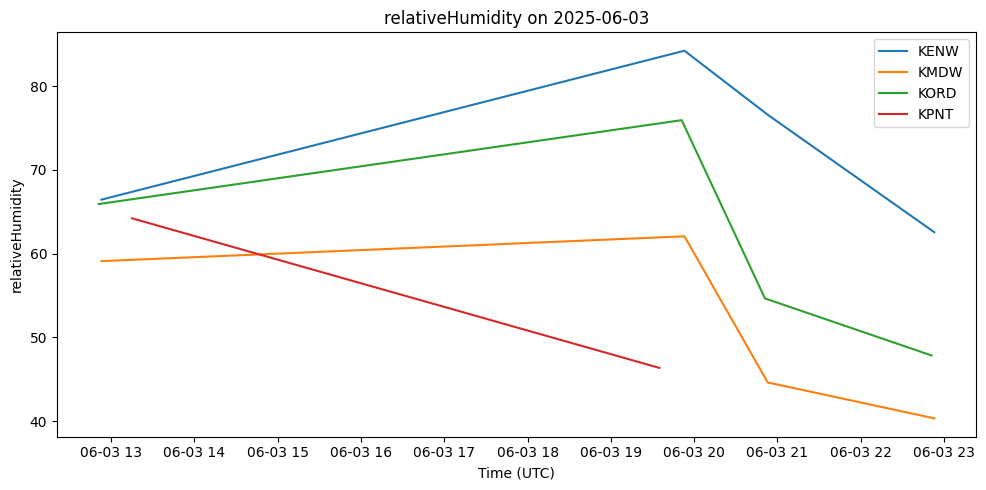

🖼️  Saved: plots/relativeHumidity_2025-06-03.png


In [43]:

# Plotting
s3 = boto3.client("s3")

for var in ["temperature", "visibility", "relativeHumidity"]:
	plt.figure(figsize=(10, 5))
	for station, group in df_all.groupby("station"):
		plt.plot(group["timestamp"], group[var], label=station)
	plt.title(f"{var} on {target_date}")
	plt.xlabel("Time (UTC)")
	plt.ylabel(var)
	plt.legend()
	plt.tight_layout()

	# Save locally
	local_path = os.path.join(LOCAL_OUTPUT_DIR, f"{var}_{target_date}.png")
	plt.savefig(local_path)
	plt.show()
	plt.close()
	print(f"🖼️  Saved: {local_path}")
	

# if __name__ == "__main__":
#     create_dashboard_local()

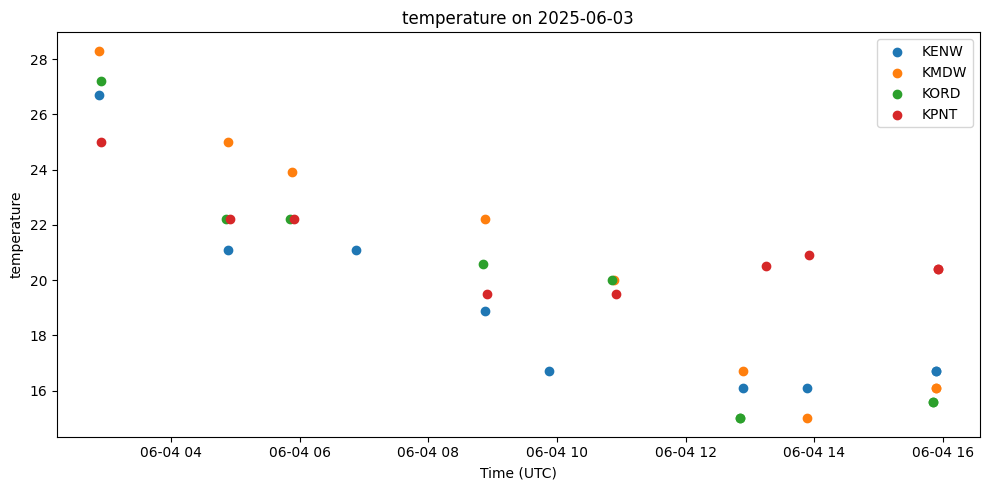

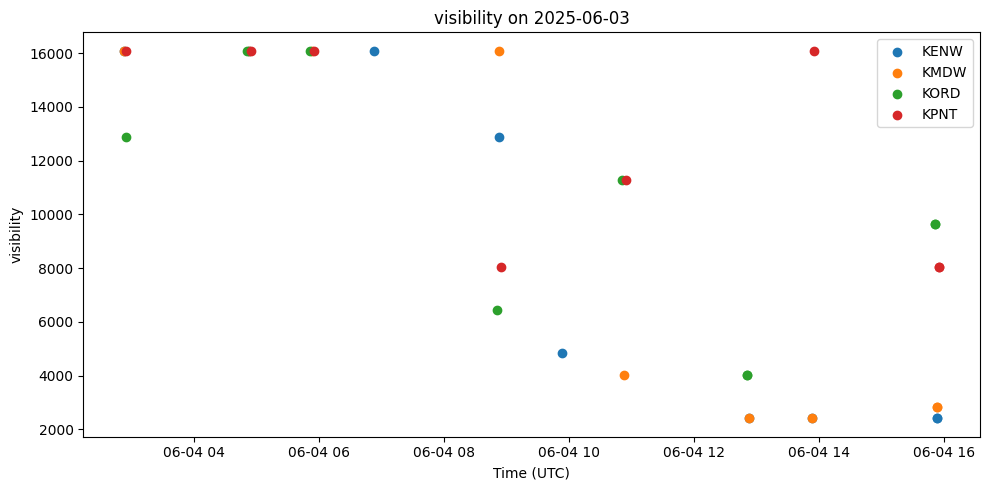

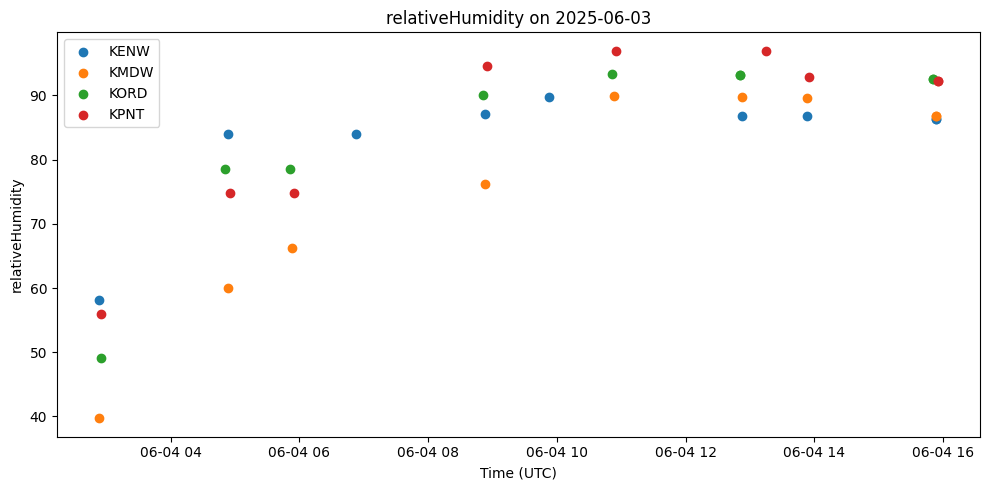

In [40]:
for var in ["temperature", "visibility", "relativeHumidity"]:
	plt.figure(figsize=(10, 5))
	for station, group in df_all.groupby("station"):
		plt.scatter(group["timestamp"], group[var], label=station)
	plt.title(f"{var} on {target_date}")
	plt.xlabel("Time (UTC)")
	plt.ylabel(var)
	plt.legend()
	plt.tight_layout()